In [1]:
import pandas as pd
import re
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv(r"/kaggle/input/biomedical-text-publication-classification/alldata_1_for_kaggle.csv",encoding='latin1')

In [3]:
print(df.shape)

(7570, 3)


In [4]:
df.head()

,Unnamed: 0,0,a
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


# Cleaning The data

**Drop uninterested columns**

In [5]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

**Rename columns**

In [6]:
df.columns=['label','text']

**Check Null values**

In [7]:
df['text'].isna().sum()

0

**Remove digits**

In [8]:
def remove_digits(text):
    return re.sub('\d+','',text)

In [9]:
df['cleaned_text']=df['text'].apply(lambda x:remove_digits(x))

**Remove punctuations**

In [10]:
import string
exclude=string.punctuation

In [11]:
def remove_punc(text):
    for i in exclude:
        text.replace(i,'')
    return text   

**Remove Stopwords**

In [12]:
from nltk.corpus import stopwords
stopwords=stopwords.words('english')

def remove_stopwords(text):
    new=' '.join(word for word in text.split() if word.lower not in stopwords)
    return new

In [13]:
df['cleaned_text']=df['cleaned_text'].apply(lambda x:remove_stopwords(x))

**Remove emojis**

In [14]:
import emoji
df['cleaned_text']=df['cleaned_text'].apply(emoji.demojize)

# Prepare data for the RNN Model

**build vocabulary for the most appearance words**

In [15]:
# build vocabulary for the most appearance words
from tensorflow.keras.preprocessing.text import Tokenizer

vocab_sz = 10000

tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(df['cleaned_text'])


**Split data**

In [16]:
x=df['cleaned_text']
y=df['label']

In [17]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

**Encoding labels**

In [18]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

**Word Embedding**

In [19]:
x_train_seq = tok.texts_to_sequences(x_train)
x_test_seq = tok.texts_to_sequences(x_test)

**calculate maxmium lengh of sequence**

In [20]:
from nltk.tokenize import word_tokenize

def get_max_len(texts):
  return max([len(word_tokenize(text)) for text in texts])
    
maxlen = get_max_len(df['cleaned_text'])

**Pad sequences to ensure that all input sequences have the same length**

In [21]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train_seq, maxlen=maxlen, padding='post', truncating='post')  
x_test = pad_sequences(x_test_seq, maxlen=maxlen, padding='post', truncating='post')

**Reshape input size**

In [22]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)  # Add feature dimension
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [23]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] )  # Add feature dimension
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1])

In [24]:
print(x_train.shape)

(6056, 5797)


# RNN

In [25]:
embedding_size = 100

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,BatchNormalization
from keras.layers import Embedding
from keras.layers import SimpleRNN


# Model: Enhanced RNN with multiple layers
model = Sequential()
model.add(Embedding(vocab_sz + 1, embedding_size, mask_zero=True, input_length=maxlen))

# Add the first RNN layer
model.add(SimpleRNN(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))  # Return sequences to pass to the next RNN layer
model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Add a second RNN layer
model.add(SimpleRNN(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))

# Add a third RNN layer
model.add(SimpleRNN(100,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))



# Add a fully connected layer
model.add(Dense(64, activation='relu'))  # Intermediate dense layer for more learning capacity
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout for dense layer

# Output layer
model.add(Dense(3, activation='softmax'))  # For classification

#model.build(input_shape=(None, maxlen)) # None for batch size, maxlen for sequence length
# Model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam',
    metrics=['accuracy']
)

In [28]:
checkpoint = EarlyStopping(monitor='val_loss',patience = 10 ,mode='max',restore_best_weights=True)
callbacks_lst = [checkpoint]

In [29]:
x_train.shape

(6056, 5797)

In [30]:
history = model.fit(x_train, y_train,
          batch_size=64,
          epochs=80,
          validation_split=0.2,
          callbacks=callbacks_lst)

Epoch 1/80


I0000 00:00:1733991363.349825      68 service.cc:145] XLA service 0x79a108002e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733991363.349881      68 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733991377.836756      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


76/76 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.3380 - loss: 1.6425 - val_accuracy: 0.2830 - val_loss: 1.1248
Epoch 2/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.3331 - loss: 1.3867 - val_accuracy: 0.2789 - val_loss: 1.1134
Epoch 3/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.3417 - loss: 1.2708 - val_accuracy: 0.3391 - val_loss: 1.1086
Epoch 4/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.3315 - loss: 1.2173 - val_accuracy: 0.3804 - val_loss: 1.1048
Epoch 5/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.3563 - loss: 1.1759 - val_accuracy: 0.3267 - val_loss: 1.1179
Epoch 6/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.3307 - loss: 1.1633 - val_accuracy: 0.3267 - val_loss: 1.1047
Epoch 7/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.3591 - loss: 1.1315 - val_accuracy: 0.3267 - val_loss: 1.0942
Epoch 8/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.3545 - loss: nan - val_accuracy: 0.3903 - val_loss: nan
E

In [31]:
loss, accuracy = model.evaluate(x_train, y_train)

print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy}")


190/190 ━━━━━━━━━━━━━━━━━━━━ 65s 342ms/step - accuracy: 0.2858 - loss: 1.1188
Train Loss: 1.1195869445800781
Train Accuracy: 0.2914465069770813


In [32]:
loss, accuracy = model.evaluate(x_test, y_test)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 349ms/step - accuracy: 0.2850 - loss: 1.1233
Test Loss: 1.1268043518066406
Test Accuracy: 0.268163800239563


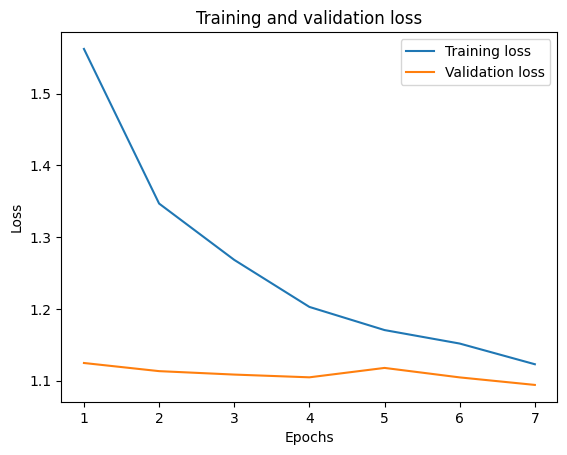

In [33]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

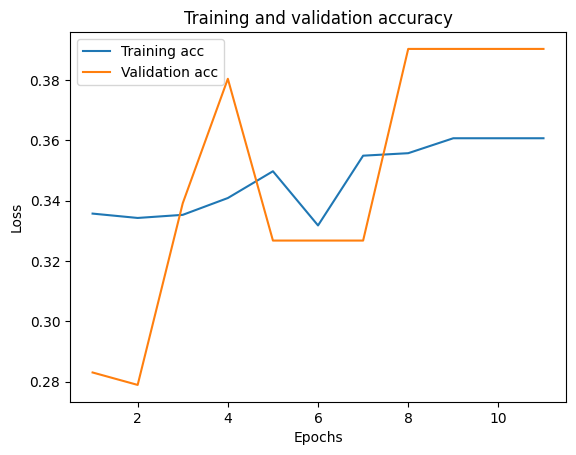

In [34]:

plt.clf()   # clear figure
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# LSTM

In [35]:
from keras.layers import LSTM

# Model: Enhanced LSTM with multiple layers
model = Sequential()
model.add(Embedding(input_dim=vocab_sz + 1, output_dim=embedding_size, mask_zero=True, input_length=maxlen))

# Add the first LSTM layer
model.add(LSTM(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))  # Return sequences to pass to the next LSTM layer
model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Add a second LSTM layer
model.add(LSTM(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))

# Add a third LSTM layer
model.add(LSTM(100,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))


# Add a fully connected layer
model.add(Dense(64, activation='relu'))  # Intermediate dense layer for more learning capacity
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(3, activation='softmax'))  # For classification

model.build(input_shape=(None, maxlen)) # None for batch size, maxlen for sequence length
# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 5797, 100)      │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 5797, 100)      │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5797, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5797, 100)      │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5797, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,248,215 (4.76 MB)

 Trainable params: 1,248,087 (4.76 MB)

 Non-trainable params: 128 (512.00 B)

In [36]:
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam',
    metrics=['accuracy']
)

In [37]:
checkpoint = EarlyStopping(monitor='val_loss',patience = 10 ,mode='max',restore_best_weights=True)
callbacks_lst = [checkpoint]

In [38]:
history = model.fit(x_train, y_train,
          batch_size=64,
          epochs=50,
          validation_split=0.2,
          callbacks=callbacks_lst)

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3071s 40s/step - accuracy: 0.5379 - loss: 0.8818 - val_accuracy: 0.9447 - val_loss: 0.7933
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3066s 40s/step - accuracy: 0.9487 - loss: 0.1566 - val_accuracy: 0.9728 - val_loss: 0.3441
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3013s 40s/step - accuracy: 0.9695 - loss: 0.0931 - val_accuracy: 0.9703 - val_loss: 0.1463
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3030s 40s/step - accuracy: 0.9698 - loss: 0.0788 - val_accuracy: 0.9703 - val_loss: 0.0716
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3035s 40s/step - accuracy: 0.9717 - loss: 0.0738 - val_accuracy: 0.9711 - val_loss: 0.0546
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3039s 40s/step - accuracy: 0.9786 - loss: 0.0518 - val_accuracy: 0.9703 - val_loss: 0.0414
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3040s 40s/step - accuracy: 0.9812 - loss: 0.0438 - val_accuracy: 0.9752 - val_loss: 0.0386
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3078s 41s/step - accuracy: 0.9807 - loss: 0.0431 - val_accu

In [39]:
loss, accuracy = model.evaluate(x_train, y_train)

print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy}")


190/190 ━━━━━━━━━━━━━━━━━━━━ 1249s 7s/step - accuracy: 0.9633 - loss: 0.7783
Train Loss: 0.7799026966094971
Train Accuracy: 0.9593791365623474


In [40]:
loss, accuracy = model.evaluate(x_test, y_test)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 315s 7s/step - accuracy: 0.9488 - loss: 0.7911
Test Loss: 0.7981860637664795
Test Accuracy: 0.9478203654289246


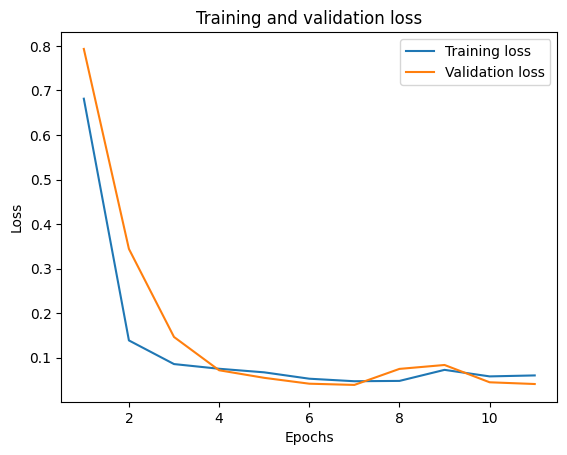

In [41]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

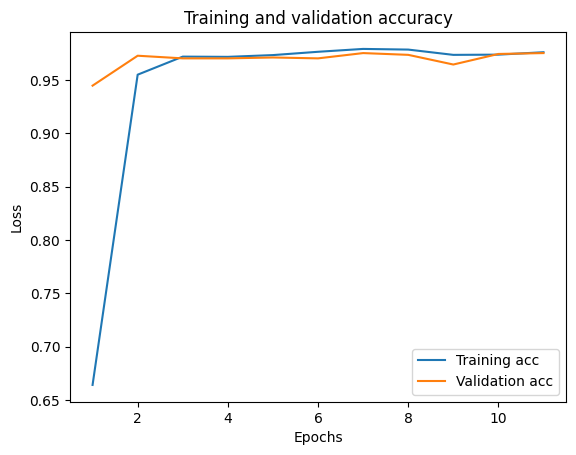

In [42]:

plt.clf()   # clear figure
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()